In [1]:
import numpy
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from scipy.stats.mstats import winsorize
from scipy.stats import entropy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from sklearn.metrics import accuracy_score
import copy
pd.set_option('display.max_rows', 200)

In [2]:
df1 = pd.read_excel('C:\\Users\\samii\\OneDrive\\桌面\\FIN_AAA.xlsx')
df2 = pd.read_excel('C:\\Users\\samii\\OneDrive\\桌面\\TECH_A.xlsx')
df3 = pd.read_excel('C:\\Users\\samii\\OneDrive\\桌面\\平均數變異數.xlsx')
df4 = pd.read_excel('C:\\Users\\samii\\OneDrive\\桌面\\大盤_ETF報酬率.xlsx')

In [3]:
# 模型效度檢驗
df1['年月'] = df1['年月'].astype('datetime64[ns]')
df2['年月'] = df2['年月'].astype('datetime64[ns]')
df_all = df1.merge(df2,how='left',on=['年月','證券代碼'])

#看前兩年模型效果
future_months = df_all['年月'][0:].unique()  
future_months_model = future_months[:132]
print(len(future_months_model))
print('資料搜集 開始：', str(future_months_model[0])[:10])
print('模型效度 開始：', str(future_months_model[12])[:10])
print('模型效度 結束：', str(future_months_model[-1])[:10])

132
資料搜集 開始： 1999-12-28
模型效度 開始： 2000-12-30
模型效度 結束： 2010-11-30


In [4]:
code_all = []
for month in range(120):
    top_150_com_df = df_all[df_all['年月']== (future_months_model[month+12])].sort_values(by=["市值(百萬元)"], ascending=[False])[:150].sort_values(by=["證券代碼"])
    top_150_com_code = list(top_150_com_df['證券代碼'])
    code_all = list(set(code_all + top_150_com_code))

# all_training_data = pd.DataFrame()
# for code in code_all:
#     train_data = pd.DataFrame()
#     for month in range(132): # 抓過去所有資料
#         data_temp = df_all[(df_all['證券代碼'] == code) & (df_all['年月']== future_months_model[month])].drop(columns=['年月', '證券代碼']).reset_index()
#         train_data = pd.concat([train_data, data_temp], axis=1)
#     all_training_data = pd.concat([all_training_data, train_data], axis=0)

In [8]:
all_training_data = pd.read_csv('C:\\Users\\samii\\OneDrive\\桌面\\前十年橫向表格.csv', low_memory=False)
all_data_float = all_training_data.drop(columns=['Unnamed: 0', '證券代碼'])
X_data = copy.deepcopy(all_data_float)
for i in range(132):
    if i == 0:
        X_data = X_data.drop(columns=['市值(百萬元)', '報酬率％_月'])
    else:
        col1 = f'市值(百萬元).{i}'
        col2 = f'報酬率％_月.{i}'
        X_data = X_data.drop(columns=[col1, col2])

return_col = []
for i in range(132):
    if i == 0:
        return_col.append('報酬率％_月')
    else:
        return_col.append(f'報酬率％_月.{i}')
y_data = all_training_data[return_col]

In [22]:
# 過去10年的模型效果
for month in range(24): # 這邊設定月份 從2000/12/31開始, 一年=12, 兩年=24
    print('-----------------------------------------------')
    print('預測月份:', str((future_months_model[month+12]))[:10])
    # 抓該下月份市值前150
    top_150_com_df = df_all[df_all['年月']== (future_months[month+12])].sort_values(by=["市值(百萬元)"], ascending=[False])[:150].sort_values(by=["證券代碼"])
    top_150_com_code = top_150_com_df['證券代碼']
    
    X_all = X_data.iloc[:,month*25:(month+12)*25]
    y_all = y_data.iloc[:,month+12:month+13]

    code_list = []
    for row in range(len(all_training_data)):
        if all_training_data.iloc[row]['證券代碼'] in list(top_150_com_code):
            code_list.append(row)

    X_150_data = X_all.iloc[code_list].reset_index()
    y_150_data = y_all.iloc[code_list].reset_index()

    df_train = pd.concat([X_150_data, y_150_data], axis=1)
    df_train = df_train.drop(columns=['index'])
    df_train = df_train.replace('- -', numpy.nan).dropna().reset_index().drop(columns=['index'])
    print(f'可從150股中選擇標的數量：{len(df_train)}')
    
    X = df_train.iloc[:,:-1]
    y = df_train.iloc[:,-1:]

    winsorized_df = pd.DataFrame()
    for col in X.columns:
        X[col] = pd.DataFrame(winsorize(X[col], limits = [0.01,0.01]))
        
    print(X.shape, y.shape)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

    rf = RandomForestRegressor(n_estimators=200, criterion = 'squared_error')
    rf.fit(x_train, np.ravel(y_train))
 
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(x_train, np.ravel(y_train>0))
    
    knn = KNeighborsRegressor(n_neighbors=2)
    knn.fit(x_train, np.ravel(y_train))
    
    linearModel = LinearRegression(fit_intercept=True)
    linearModel.fit(x_train, np.ravel(y_train))
    
    lg = LogisticRegression(max_iter=500)
    lg.fit(x_train, np.ravel(y_train)>0)
    
    print('模型預測指標：')
    print(f'RF 訓練集 MSE: {mean_squared_error(rf.predict(x_train),y_train)}')
    print(f'RF 測試集 MSE: {mean_squared_error(rf.predict(x_test),y_test)}')
    print(f'KNN 訓練集 MSE: {mean_squared_error(knn.predict(x_train),y_train)}')
    print(f'KNN 測試集 MSE: {mean_squared_error(knn.predict(x_test),y_test)}')
    print(f'LR 訓練集 MSE: {mean_squared_error(linearModel.predict(x_train),y_train)}')
    print(f'LR 測試集 MSE: {mean_squared_error(linearModel.predict(x_test),y_test)}')
    print(f'RFC 訓練集 ACC: {accuracy_score(rfc.predict(x_train),y_train>60)}')
    print(f'RFC 測試集 ACC: {accuracy_score(rfc.predict(x_test),y_test>60)}')
    print(f'LG 測試集 ACC: {accuracy_score(lg.predict(x_train),y_train>60)}')
    print(f'LG 測試集 ACC: {accuracy_score(lg.predict(x_train),y_train>60)}')

-----------------------------------------------
預測月份: 2000-12-30
可從150股中選擇標的數量：84
(84, 300) (84, 1)
(67, 300) (67, 1)
(17, 300) (17, 1)
模型預測指標：
RF 訓練集 MSE: 16.722187198196472
RF 測試集 MSE: 193.8085791801825
KNN 訓練集 MSE: 64.48896750914179
KNN 測試集 MSE: 107.6884298192647
LR 訓練集 MSE: 5.030115819405242e-27
LR 測試集 MSE: 691.337131704115
RFC 訓練集 ACC: 0.5373134328358209
RFC 測試集 ACC: 0.47058823529411764
LG 測試集 ACC: 0.5373134328358209
LG 測試集 ACC: 0.5373134328358209
-----------------------------------------------
預測月份: 2001-01-31
可從150股中選擇標的數量：87
(87, 300) (87, 1)
(69, 300) (69, 1)
(18, 300) (18, 1)
模型預測指標：
RF 訓練集 MSE: 25.249160141232583
RF 測試集 MSE: 103.5162258010676
KNN 訓練集 MSE: 112.3309737360507
KNN 測試集 MSE: 374.3032137436111
LR 訓練集 MSE: 8.807012243652974e-26
LR 測試集 MSE: 878.6242056628205
RFC 訓練集 ACC: 0.21739130434782608
RFC 測試集 ACC: 0.05555555555555555
LG 測試集 ACC: 0.21739130434782608
LG 測試集 ACC: 0.21739130434782608
-----------------------------------------------
預測月份: 2001-02-27
可從150股中選擇標的數量：86


C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 7.173208985728074
RF 測試集 MSE: 123.09765377092066
KNN 訓練集 MSE: 15.516143756617646
KNN 測試集 MSE: 139.41427450666663
LR 訓練集 MSE: 5.45775176657889e-27
LR 測試集 MSE: 536.2759749397857
RFC 訓練集 ACC: 0.6323529411764706
RFC 測試集 ACC: 0.7777777777777778
LG 測試集 ACC: 0.6323529411764706
LG 測試集 ACC: 0.6323529411764706
-----------------------------------------------
預測月份: 2001-07-31
可從150股中選擇標的數量：88
(88, 300) (88, 1)
(70, 300) (70, 1)
(18, 300) (18, 1)


C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 11.94414056083561
RF 測試集 MSE: 171.8642837964458
KNN 訓練集 MSE: 49.142674785428575
KNN 測試集 MSE: 225.93814461958334
LR 訓練集 MSE: 1.878517864340029e-26
LR 測試集 MSE: 1274.8452159571011
RFC 訓練集 ACC: 0.8285714285714286
RFC 測試集 ACC: 1.0
LG 測試集 ACC: 0.8285714285714286
LG 測試集 ACC: 0.8285714285714286
-----------------------------------------------
預測月份: 2001-08-31
可從150股中選擇標的數量：94
(94, 300) (94, 1)
(75, 300) (75, 1)
(19, 300) (19, 1)
模型預測指標：
RF 訓練集 MSE: 20.037827445918104
RF 測試集 MSE: 63.379197367877566
KNN 訓練集 MSE: 84.40573751049999
KNN 測試集 MSE: 114.66760491355265
LR 訓練集 MSE: 1.0133715734462258e-26
LR 測試集 MSE: 1393.1247464986693
RFC 訓練集 ACC: 0.29333333333333333
RFC 測試集 ACC: 0.21052631578947367
LG 測試集 ACC: 0.29333333333333333
LG 測試集 ACC: 0.29333333333333333
-----------------------------------------------
預測月份: 2001-09-28
可從150股中選擇標的數量：92
(92, 300) (92, 1)
(73, 300) (73, 1)
(19, 300) (19, 1)
模型預測指標：
RF 訓練集 MSE: 10.888460614414292
RF 測試集 MSE: 96.8550092453054
KNN 訓練集 MSE: 34.9969719

C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 11.768323377891809
RF 測試集 MSE: 104.58458552025122
KNN 訓練集 MSE: 35.42146007151317
KNN 測試集 MSE: 189.35047980578943
LR 訓練集 MSE: 3.4687414995298857e-26
LR 測試集 MSE: 312.6692931359385
RFC 訓練集 ACC: 0.32894736842105265
RFC 測試集 ACC: 0.15789473684210525
LG 測試集 ACC: 0.32894736842105265
LG 測試集 ACC: 0.32894736842105265
-----------------------------------------------
預測月份: 2001-12-31
可從150股中選擇標的數量：92
(92, 300) (92, 1)
(73, 300) (73, 1)
(19, 300) (19, 1)
模型預測指標：
RF 訓練集 MSE: 29.4892737355008
RF 測試集 MSE: 174.33666385103183
KNN 訓練集 MSE: 99.27509858010274
KNN 測試集 MSE: 177.81786899499997
LR 訓練集 MSE: 9.092514652744017e-27
LR 測試集 MSE: 363.6991845859295
RFC 訓練集 ACC: 0.0410958904109589
RFC 測試集 ACC: 0.05263157894736842
LG 測試集 ACC: 0.0410958904109589
LG 測試集 ACC: 0.0410958904109589
-----------------------------------------------
預測月份: 2002-01-31
可從150股中選擇標的數量：88
(88, 300) (88, 1)
(70, 300) (70, 1)
(18, 300) (18, 1)
模型預測指標：
RF 訓練集 MSE: 21.079187883288135
RF 測試集 MSE: 90.36574010515046
KNN 訓練集 M

C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 27.42669883355741
RF 測試集 MSE: 119.67465717303857
KNN 訓練集 MSE: 118.77104603193663
KNN 測試集 MSE: 125.3528287566667
LR 訓練集 MSE: 2.998128142389001e-26
LR 測試集 MSE: 263.71497648698875
RFC 訓練集 ACC: 0.4084507042253521
RFC 測試集 ACC: 0.3333333333333333
LG 測試集 ACC: 0.4084507042253521
LG 測試集 ACC: 0.4084507042253521
-----------------------------------------------
預測月份: 2002-05-31
可從150股中選擇標的數量：91
(91, 300) (91, 1)
(72, 300) (72, 1)
(19, 300) (19, 1)
模型預測指標：
RF 訓練集 MSE: 21.65698830127766
RF 測試集 MSE: 133.60551653116724
KNN 訓練集 MSE: 58.057288845625
KNN 測試集 MSE: 320.9448834089473
LR 訓練集 MSE: 2.4290705777897193e-26
LR 測試集 MSE: 2200.588335074136
RFC 訓練集 ACC: 0.7638888888888888
RFC 測試集 ACC: 0.8947368421052632
LG 測試集 ACC: 0.7638888888888888
LG 測試集 ACC: 0.7638888888888888
-----------------------------------------------
預測月份: 2002-06-28
可從150股中選擇標的數量：90
(90, 300) (90, 1)
(72, 300) (72, 1)
(18, 300) (18, 1)
模型預測指標：
RF 訓練集 MSE: 10.39947044587317
RF 測試集 MSE: 64.62167986853723
KNN 訓練集 MSE: 40.0

C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 19.40106800114238
RF 測試集 MSE: 108.00590862846236
KNN 訓練集 MSE: 78.44575944036232
KNN 測試集 MSE: 174.37029656361108
LR 訓練集 MSE: 4.405714275516274e-27
LR 測試集 MSE: 772.490598563108
RFC 訓練集 ACC: 0.4927536231884058
RFC 測試集 ACC: 0.6111111111111112
LG 測試集 ACC: 0.4927536231884058
LG 測試集 ACC: 0.4927536231884058
-----------------------------------------------
預測月份: 2002-08-30
可從150股中選擇標的數量：88
(88, 300) (88, 1)
(70, 300) (70, 1)
(18, 300) (18, 1)


C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型預測指標：
RF 訓練集 MSE: 10.624517209837988
RF 測試集 MSE: 42.85451502351296
KNN 訓練集 MSE: 28.4529510435
KNN 測試集 MSE: 61.89857211499999
LR 訓練集 MSE: 6.772571363137706e-27
LR 測試集 MSE: 259.49637397063015
RFC 訓練集 ACC: 0.6571428571428571
RFC 測試集 ACC: 0.8333333333333334
LG 測試集 ACC: 0.6571428571428571
LG 測試集 ACC: 0.6571428571428571
-----------------------------------------------
預測月份: 2002-09-30
可從150股中選擇標的數量：86
(86, 300) (86, 1)
(68, 300) (68, 1)
(18, 300) (18, 1)
模型預測指標：
RF 訓練集 MSE: 7.266157610598694
RF 測試集 MSE: 65.79797439493586
KNN 訓練集 MSE: 38.13312002345589
KNN 測試集 MSE: 144.15506683291667
LR 訓練集 MSE: 8.762942093939054e-27
LR 測試集 MSE: 1285.122892628286
RFC 訓練集 ACC: 0.9558823529411765
RFC 測試集 ACC: 1.0
LG 測試集 ACC: 0.9558823529411765
LG 測試集 ACC: 0.9558823529411765
-----------------------------------------------
預測月份: 2002-10-31
可從150股中選擇標的數量：89
(89, 300) (89, 1)
(71, 300) (71, 1)
(18, 300) (18, 1)
模型預測指標：
RF 訓練集 MSE: 22.193034997627002
RF 測試集 MSE: 241.54075704642707
KNN 訓練集 MSE: 84.71063314461269
KNN

In [23]:
return_months = df_all['年月'][77000:].unique()  
future_months = df_all['年月'][85000:].unique()  
future_months_pred = future_months[:]
code_all = []
for month in range(133):
    top_150_com_df = df_all[df_all['年月']== (future_months_pred[month+12])].sort_values(by=["市值(百萬元)"], ascending=[False])[:150].sort_values(by=["證券代碼"])
    top_150_com_code = list(top_150_com_df['證券代碼'])
    code_all = list(set(code_all + top_150_com_code))

In [24]:
# 抓股價用
# return_months = df_all['年月'][77000:].unique()  
# print(len(return_months))
# all_return_data = pd.DataFrame()
# for code in code_all:
#     return_data = pd.DataFrame()
#     for month in range(156): 
#         data_temp = pd.DataFrame(df3[(df3['證券代碼'] == code) & (df3['年月']== return_months[month])]['收盤價(元)_月']).reset_index()
#         return_data = pd.concat([return_data, data_temp], axis=1)
#     all_return_data = pd.concat([all_return_data, return_data], axis=0)
# all_return_data.shape
# len(code_all)

In [25]:
# all_return_data = all_return_data.drop(columns=['index'])
# all_return_data.to_csv('兩年報酬橫向表格.csv', encoding='utf-8-sig')
# # 抓之前的股價
all_return_data = pd.read_csv('C:\\Users\\samii\\OneDrive\\桌面\\兩年報酬橫向表格.csv', encoding='utf-8-sig')
all_return_data = all_return_data.drop(columns=['Unnamed: 0'])
all_return_data = all_return_data.T 
all_return_data.columns = code_all
for col in all_return_data.columns:
    all_return_data[col] = all_return_data[col].fillna(all_return_data[col].mean())
all_return_data.set_index(return_months, inplace=True)
all_return_data.shape

(156, 272)

In [26]:
# 預測
df1['年月'] = df1['年月'].astype('datetime64[ns]')
df2['年月'] = df2['年月'].astype('datetime64[ns]')
df_all = df1.merge(df2,how='left',on=['年月','證券代碼'])

future_months = df_all['年月'][85000:].unique()  
future_months_pred = future_months[:]
print('資料搜集 開始：', str(future_months_pred[0])[:10])
print('模型預測 開始：', str(future_months_pred[12])[:10])
print('模型預測 結束：', str(future_months_pred[-1])[:10])

資料搜集 開始： 2009-12-31
模型預測 開始： 2010-12-31
模型預測 結束： 2021-12-30


In [27]:
# all_predict_data = pd.DataFrame()
# for code in code_all:
#     train_data = pd.DataFrame()
#     for month in range(145): # 抓過去
#         data_temp = df_all[(df_all['證券代碼'] == code) & (df_all['年月']== future_months_pred[month])].drop(columns=['年月', '證券代碼']).reset_index()
#         train_data = pd.concat([train_data, data_temp], axis=1)
#     all_predict_data = pd.concat([all_predict_data, train_data], axis=0)

In [29]:
# all_predict_data.to_csv('後續預測表格.csv')
all_predict_data = pd.read_csv('C:\\Users\\samii\\OneDrive\\桌面\\後續預測表格.csv', low_memory=False)
all_predcict_float = all_predict_data.drop(columns=['Unnamed: 0'])
X_data = copy.deepcopy(all_predcict_float)
all_predict_data.insert(0, '證券代碼', code_all)
for i in range(145):
    if i == 0:
        X_data = X_data.drop(columns=['市值(百萬元)', '報酬率％_月', 'index'])
    else:
        col1 = f'市值(百萬元).{i}'
        col2 = f'報酬率％_月.{i}'
        col3 = f'index.{i}'
        X_data = X_data.drop(columns=[col1, col2, col3])


return_col = []
for i in range(145):
    if i == 0:
        return_col.append('報酬率％_月')
    else:
        return_col.append(f'報酬率％_月.{i}')
y_data = all_predict_data[return_col]
X_data

,週轉率％_月,股價淨值比-TEJ,股價營收比-TEJ,高低價差%,單月營收成長率％,外資總投資比率%-TSE,融資增減比率,融資使用率,融券增減比率,融券使用率,...,月DIF.144,月MACD.144,月DIF-月MACD.144,月+DI(14).144,月-DI(14).144,月ADX(14).144,Beta係數(21D).144,年化波動度(21D).144,乖離率(20日).144,近三月歷史波動率(%).144
0,4.0092,3.61,6.49,6.7103,131.49,73.90,-2.26,0.51,2.83,0.11,...,78.742,81.252,-2.51,31.77,14.92,44.73,1.5023,0.157,1.87,16.88
1,47.9853,1.10,0.59,28.2869,38.82,9.63,1.27,36.15,-5.47,0.51,...,30.703,36.735,-6.032,25.24,15.24,46.07,-0.6262,0.405,-5.69,44.56
2,44.0800,4.96,4.63,22.2892,71.14,25.07,-6.04,14.27,-4.61,5.24,...,5.152,4.434,0.718,35,14.09,29.78,0.5428,0.144,2.06,31.99
3,4.4720,4.88,4.15,6.2810,0.78,33.12,-1.33,0.05,-1.50,0.01,...,0.61,0.32,0.29,23.79,15.57,16.28,0.5689,0.073,1.07,6.61
4,8.6329,1.46,5.20,5.3651,-3.05,37.40,-0.66,3.90,-5.41,0.09,...,3.687,3.661,0.026,29.7,12.46,41.73,0.0354,0.101,1.15,11.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,7.0826,11.90,10.02,7.4813,14.54,30.65,-0.57,6.74,-0.58,0.94,...,3.242,1.961,1.281,25.08,23.23,14.95,0.2621,0.113,0.92,20.07
268,44.4220,0.91,2.06,53.9326,120.56,7.54,-2.35,32.98,9.47,2.01,...,1.041,8.343,-7.302,23.31,23.55,17.16,0.3026,0.229,0.33,39.04
269,17.6988,2.49,1.77,7.9503,-51.37,35.68,-0.49,18.69,-4.24,5.68,...,5.255,5.261,-0.006,29.87,9.85,41.8,0.1325,0.079,-0.63,11.19
270,19.3530,0.85,0.61,12.6667,-13.24,9.95,0.01,34.32,-0.75,0.81,...,1.7,2.184,-0.484,24.38,16.57,38.13,0.1263,0.09,1.79,12.69


In [30]:
return_list = []
for month in range(len(future_months)-13):
# for month in range(5):
    print('-----------------------------------------------')
    print('預測月份:', str((future_months[month+12]))[:10])
    # 抓該下月份市值前150
    top_150_com_df = df_all[df_all['年月']== (future_months[month+12])].sort_values(by=["市值(百萬元)"], ascending=[False])[:150].sort_values(by=["證券代碼"])
    top_150_com_code = top_150_com_df['證券代碼']
    # all_training_data = pd.DataFrame()

    print(f'從{str(future_months[month + 0])[:10]} 抓到 {str(future_months[month+12])[:10]}')

    X_all = X_data.iloc[:,month*25:(month+13)*25]
    y_all = y_data.iloc[:,month+12:month+14]

    code_list = []
    for row in range(len(all_predict_data)):
        if all_predict_data.iloc[row]['證券代碼'] in list(top_150_com_code):
            code_list.append(row)
            
    X_code = pd.DataFrame({'證券代碼':code_all})
    X_code = X_code.iloc[code_list].reset_index()
    X_150_data = X_all.iloc[code_list].reset_index()
    y_150_data = y_all.iloc[code_list].reset_index()

    df_train = pd.concat([X_code, X_150_data, y_150_data], axis=1)
    df_train = df_train.drop(columns=['index'])
    df_train = df_train.replace('- -', numpy.nan).dropna().reset_index().drop(columns=['index'])
    
    X_code = df_train.iloc[:,0:1]
    X = df_train.iloc[:,1:301]
    x_out_sample = df_train.iloc[:,26:326]
    y = df_train.iloc[:,326:327]
    real = df_train.iloc[:,327:328]
    winsorized_df = pd.DataFrame()
    for col in X.columns:
        X[col] = pd.DataFrame(winsorize(X[col], limits = [0.01,0.01]))
        
    print(f'可選檔數(一年內有完整資料):{len(X)}')
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    data_list = []
    print('----------------------------RF回歸結果----------------------------')
    rf = RandomForestRegressor(n_estimators=100, criterion = 'squared_error')
    rf.fit(x_train, np.ravel(y_train))
    x_out_sample.columns = x_train.columns
    rf_outcome = pd.concat([X_code, pd.DataFrame({'預測報酬':rf.predict(x_out_sample)})], axis=1)
    rf_outcome['真實報酬'] = real
    rf_outcome = rf_outcome.sort_values(by=['預測報酬'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)

    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']

    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x1 = rf_outcome['最小變異法(報酬)'].mean()
    x2 = rf_outcome['平均法(報酬)'].mean()
    x3 = rf_outcome['夏普最優法(報酬)'].mean()
    
    print('\n')
    print('----------------------------KNN回歸結果----------------------------')
    rf = KNeighborsRegressor(n_neighbors=10)
    rf.fit(x_train, np.ravel(y_train))
    x_out_sample.columns = x_train.columns
    rf_outcome = pd.concat([X_code, pd.DataFrame({'預測報酬':rf.predict(x_out_sample)}), real], axis=1)
    rf_outcome = rf_outcome.sort_values(by=['預測報酬'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']
    
    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x4 = rf_outcome['最小變異法(報酬)'].mean()
    x5 = rf_outcome['平均法(報酬)'].mean()
    x6 = rf_outcome['夏普最優法(報酬)'].mean()
    
    print('\n')
    print('----------------------------線性回歸結果----------------------------')
    rf = LinearRegression()
    rf.fit(x_train, np.ravel(y_train))
    x_out_sample.columns = x_train.columns
    rf_outcome = pd.concat([X_code, pd.DataFrame({'預測報酬':rf.predict(x_out_sample)}), real], axis=1)
    rf_outcome = rf_outcome.sort_values(by=['預測報酬'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']
    
    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x7 = rf_outcome['最小變異法(報酬)'].mean()
    x8 = rf_outcome['平均法(報酬)'].mean()
    x9 = rf_outcome['夏普最優法(報酬)'].mean()
    
    print('\n')
    print('----------------------------RF分類結果----------------------------')
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(x_train, np.ravel(y_train>0))
    x_out_sample.columns = x_train.columns
    prob_list = []
    for i in (rf.predict_proba(x_out_sample)):
        prob_list.append(i[0])
    rf_outcome = pd.concat([X_code, pd.DataFrame({'上漲機率':prob_list}), real], axis=1)
    rf_outcome = rf_outcome.sort_values(by=['上漲機率'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)

    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']

    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x10 = rf_outcome['最小變異法(報酬)'].mean()
    x11 = rf_outcome['平均法(報酬)'].mean()
    x12 = rf_outcome['夏普最優法(報酬)'].mean()
    
    print('\n')
    print('----------------------------羅吉斯分類結果----------------------------')
    rf = LogisticRegression(max_iter=2000)
    rf.fit(x_train, np.ravel(y_train>0))
    x_out_sample.columns = x_train.columns
    prob_list = []
    for i in (rf.predict_proba(x_out_sample)):
        prob_list.append(i[0])
    rf_outcome = pd.concat([X_code, pd.DataFrame({'上漲機率':prob_list}), real], axis=1)
    rf_outcome = rf_outcome.sort_values(by=['上漲機率'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)
        
    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']
    
    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x13 = rf_outcome['最小變異法(報酬)'].mean()
    x14 = rf_outcome['平均法(報酬)'].mean()
    x15 = rf_outcome['夏普最優法(報酬)'].mean()
    
    print('\n')
    print('----------------------------神經網路分類結果----------------------------')
    rf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 3), random_state=1)
    rf.fit(x_train, np.ravel(y_train>0))
    x_out_sample.columns = x_train.columns
    prob_list = []
    for i in (rf.predict_proba(x_out_sample)):
        prob_list.append(i[0])
    rf_outcome = pd.concat([X_code, pd.DataFrame({'上漲機率':prob_list}), real], axis=1)
    rf_outcome = rf_outcome.sort_values(by=['上漲機率'], ascending=False)[0:25]
    month_choose_25 = list(rf_outcome['證券代碼'])
    df = all_return_data.iloc[month:month+24]
    df = df.loc[:,month_choose_25]
    cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov().fillna(0)
    corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr().fillna(0)
    ind_er = df.resample('Y').last().pct_change().mean()
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    num_assets = len(df.columns)
    num_portfolios = 1500
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        ann_sd = sd*np.sqrt(250) 
        p_vol.append(ann_sd)
        
    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
    portfolios  = pd.DataFrame(data)
    min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    min_vol_port = pd.DataFrame({'權重':list(min_vol_port[2:])})
    rf = 0.01
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
    optimal_risky_port = pd.DataFrame({'夏普最優權重':list(optimal_risky_port[2:])})
    rf_outcome.reset_index(inplace=True)
    weights_avg = [(1/25)] * 25
    weights_avg = pd.DataFrame({'平均權重':list(weights_avg)})
    rf_outcome = pd.concat([rf_outcome, min_vol_port, optimal_risky_port, weights_avg], ignore_index=True, axis=1)
    rf_outcome = rf_outcome.iloc[:,1:]
    rf_outcome.columns = ['證券代碼', '預測報酬', '真實報酬', '最小變異法權重', '夏普最優權重','平均權重']
    
    rf_outcome['最小變異法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['最小變異法權重']
    rf_outcome['平均法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['平均權重']
    rf_outcome['夏普最優法(報酬)'] = rf_outcome['真實報酬'] * rf_outcome['夏普最優權重']
    print(rf_outcome)
    print('最小變異法報酬: ', rf_outcome['最小變異法(報酬)'].mean())
    print('平均法報酬: ', rf_outcome['平均法(報酬)'].mean())
    print('夏普最優報酬: ', rf_outcome['夏普最優法(報酬)'].mean())
    x16 = rf_outcome['最小變異法(報酬)'].mean()
    x17 = rf_outcome['平均法(報酬)'].mean()
    x18 = rf_outcome['夏普最優法(報酬)'].mean()
    
    data_list = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18]
    return_list.append(data_list)
    
    result = pd.DataFrame(return_list)
    result.columns = ['RF_均等權重法', 'RF_平均數變異數法', 'RF_夏普最優',
                  'KNN_均等權重法', 'KNN_平均數變異數法','KNN_夏普最優', 
                  'LR_均等權重法', 'LR_平均數變異數法', 'LR_夏普最優', 
                  'RFC_均等權重法', 'RFC_平均數變異數法', 'RFC_夏普最優',
                  'LG_均等權重法', 'LG_平均數變異數法', 'LG_夏普最優',
                  'ANN_均等權重法', 'ANN_平均數變異數法', 'ANN_夏普最優',]


-----------------------------------------------
預測月份: 2010-12-31
從2009-12-31 抓到 2010-12-31
可選檔數(一年內有完整資料):121
----------------------------RF回歸結果----------------------------
        證券代碼       預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0    2511 太子  25.318648   3.8910  0.038539  0.025289  0.04   0.149957   
1    1503 士電  23.119013  -3.5534  0.005079  0.080669  0.04  -0.018046   
2    2382 廣達  20.875399   2.2725  0.069311  0.060922  0.04   0.157510   
3    5534 長虹  19.358542   4.8326  0.073268  0.059848  0.04   0.354077   
4   9907 統一實  19.094622  -0.5588  0.066373  0.066165  0.04  -0.037089   
5    1304 台聚  19.035881  11.5741  0.026652  0.039000  0.04   0.308476   
6    1722 台肥  19.023738   1.3561  0.037958  0.043959  0.04   0.051475   
7    2002 中鋼  18.378680  24.6286  0.047757  0.019764  0.04   1.176185   
8   2891 中信金  18.095789  15.8877  0.001188  0.014874  0.04   0.018872   
9   2888 新光金  17.800050  -4.4555  0.020847  0.009164  0.04  -0.092883   
10   5522 遠雄  17.561613 

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


         證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0     1326 台化   1.0   0.1419  0.008913  0.003177  0.04   0.001265  0.005676   
1     2393 億光   1.0   2.2988  0.063710  0.006733  0.04   0.146456  0.091952   
2     2049 上銀   1.0  10.2190  0.014673  0.008445  0.04   0.149946  0.408760   
3     2382 廣達   1.0   0.8619  0.007807  0.013148  0.04   0.006729  0.034476   
4    2547 日勝生   1.0  -1.3031  0.086387  0.058455  0.04  -0.112571 -0.052124   
5     2349 錸德   1.0   1.1537  0.003738  0.036952  0.04   0.004313  0.046148   
6    2882 國泰金   1.0  -5.8064  0.015508  0.059405  0.04  -0.090048 -0.232256   
7     2903 遠百   1.0  -3.0243  0.024031  0.088260  0.04  -0.072678 -0.120972   
8    2880 華南金   1.0   7.3824  0.030296  0.034060  0.04   0.223654  0.295296   
9     1101 台泥   1.0 -16.8421  0.098765  0.054669  0.04  -1.663416 -0.673684   
10   3702 大聯大   1.0   5.5118  0.028539  0.049507  0.04   0.157299  0.220472   
11    2392 正崴   1.0   3.1899  0.072189  0.082071  0.

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


         證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0     1326 台化  1.000000  -3.8276  0.009803  0.071689  0.04  -0.037523   
1    2883 開發金  1.000000   6.9998  0.009420  0.072125  0.04   0.065941   
2     2606 裕民  1.000000  -8.9947  0.049951  0.022847  0.04  -0.449290   
3     5534 長虹  1.000000   6.2963  0.036590  0.016600  0.04   0.230380   
4   2449 京元電子  1.000000  10.1587  0.068942  0.056307  0.04   0.700365   
5     2354 鴻準  1.000000   5.0554  0.066068  0.031586  0.04   0.334000   
6    2344 華邦電  1.000000   0.9009  0.030822  0.077056  0.04   0.027768   
7     2103 台橡  1.000000   1.1236  0.050687  0.054616  0.04   0.056952   
8     2511 太子  1.000000  -3.1712  0.011345  0.044186  0.04  -0.035979   
9     1301 台塑  1.000000  -1.1844  0.071520  0.024280  0.04  -0.084708   
10    2101 南港  1.000000   4.4176  0.054392  0.073394  0.04   0.240283   
11    9933 中鼎  1.000000  -5.7996  0.071382  0.033485  0.04  -0.413987   
12    3189 景碩  1.000000   6.8735  0.022840  0.04544

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0      2885 元大金   1.0   2.5300  0.089752  0.034617  0.04   0.227074  0.101200   
1       6116 彩晶   1.0  -0.8377  0.050166  0.080823  0.04  -0.042024 -0.033508   
2       2511 太子   1.0   3.5322  0.046885  0.067810  0.04   0.165608  0.141288   
3      6505 台塑化   1.0   4.3303  0.025805  0.000003  0.04   0.111744  0.173212   
4       2603 長榮   1.0  14.5207  0.014511  0.002220  0.04   0.210705  0.580828   
5      2882 國泰金   1.0   1.7717  0.002602  0.020071  0.04   0.004611  0.070868   
6    4958 臻鼎-KY   1.0   2.0652  0.087802  0.041296  0.04   0.181329  0.082608   
7      9907 統一實   1.0   2.3121  0.018675  0.080858  0.04   0.043179  0.092484   
8       4938 和碩   1.0  -3.0132  0.058804  0.016959  0.04  -0.177188 -0.120528   
9       2548 華固   1.0  -5.4838  0.073845  0.049794  0.04  -0.404953 -0.219352   
10     9945 潤泰新   1.0  -2.0409  0.035646  0.023217  0.04  -0.072750 -0.081636   
11      3231 緯創   1.0   3.04

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


         證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0     2204 中華  0.999795  -1.5848  0.001746  0.069927  0.04  -0.002768   
1     5522 遠雄  0.999795   3.1248  0.024701  0.071757  0.04   0.077184   
2     3044 健鼎  0.999795  -0.5502  0.010128  0.022142  0.04  -0.005573   
3     1605 華新  0.999795   2.1540  0.010923  0.006882  0.04   0.023528   
4     2355 敬鵬  0.999795  -0.7577  0.077872  0.045627  0.04  -0.059004   
5    3682 亞太電  0.999795  10.2856  0.052776  0.073492  0.04   0.542833   
6    9917 中保科  0.999795  -1.7031  0.026820  0.010204  0.04  -0.045678   
7     1227 佳格  0.999795  -4.1413  0.052237  0.031190  0.04  -0.216327   
8     1319 東陽  0.999795   1.0203  0.033640  0.058783  0.04   0.034323   
9     3037 欣興  0.999795  -0.2008  0.079092  0.064427  0.04  -0.015882   
10    2606 裕民  0.999795   1.9887  0.079696  0.030608  0.04   0.158492   
11    2609 陽明  0.999795  -0.2107  0.081793  0.007830  0.04  -0.017234   
12  2449 京元電子  0.999795   0.0001  0.057484  0.05042

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0       1326 台化   1.0   0.7751  0.050600  0.033006  0.04   0.039220  0.031004   
1      2886 兆豐金   1.0  -0.6493  0.000007  0.011845  0.04  -0.000005 -0.025972   
2      2891 中信金   1.0 -13.5204  0.065885  0.085048  0.04  -0.890788 -0.540816   
3       3044 健鼎   1.0  -0.3644  0.023264  0.077149  0.04  -0.008477 -0.014576   
4       2317 鴻海   1.0  -6.6665  0.059203  0.033003  0.04  -0.394679 -0.266660   
5   6415 矽力*-KY   1.0  27.6159  0.060602  0.035570  0.04   1.673568  1.104636   
6       5522 遠雄   1.0  12.3015  0.013139  0.062749  0.04   0.161633  0.492060   
7      2912 統一超   1.0  -2.9124  0.082622  0.001082  0.04  -0.240629 -0.116496   
8       2201 裕隆   1.0  -3.9242  0.040722  0.053865  0.04  -0.159801 -0.156968   
9       2231 為升   1.0   4.7905  0.016317  0.060989  0.04   0.078167  0.191620   
10      1536 和大   1.0  -6.9068  0.018863  0.019418  0.04  -0.130281 -0.276272   
11     2882 國泰金   1.0   8.95

C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0      2105 正新   1.0  -4.8194  0.073150  0.063126  0.04  -0.352537 -0.192776   
1      2451 創見   1.0  -5.7090  0.051201  0.022571  0.04  -0.292307 -0.228360   
2      6239 力成   1.0  -9.0232  0.017451  0.051534  0.04  -0.157462 -0.360928   
3      1216 統一   1.0  -5.6312  0.028141  0.010908  0.04  -0.158470 -0.225248   
4     8454 富邦媒   1.0  -0.8197  0.029827  0.058013  0.04  -0.024449 -0.032788   
5      2615 萬海   1.0 -11.3360  0.071498  0.067260  0.04  -0.810496 -0.453440   
6     2227 裕日車   1.0  -8.7691  0.072147  0.025269  0.04  -0.632665 -0.350764   
7      1301 台塑   1.0   4.3236  0.072311  0.022277  0.04   0.312643  0.172944   
8   2923 鼎固-KY   1.0 -10.9523  0.006167  0.101962  0.04  -0.067538 -0.438092   
9     2912 統一超   1.0   1.5248  0.039384  0.006934  0.04   0.060053  0.060992   
10     3044 健鼎   1.0  -2.2068  0.014382  0.080005  0.04  -0.031739 -0.088272   
11     2059 川湖   1.0  15.6592  0.060352 

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0       1326 台化   1.0  -2.9179  0.000096  0.004295  0.04  -0.000280 -0.116716   
1       1802 台玻   1.0   0.2294  0.023819  0.059527  0.04   0.005464  0.009176   
2       2409 友達   1.0 -12.7529  0.065966  0.016865  0.04  -0.841262 -0.510116   
3      2892 第一金   1.0   1.4673  0.073159  0.022992  0.04   0.107347  0.058692   
4       1101 台泥   1.0  12.3136  0.041115  0.083645  0.04   0.506270  0.492544   
5      2498 宏達電   1.0  -1.2048  0.077744  0.019761  0.04  -0.093666 -0.048192   
6   6456 GIS-KY   1.0   2.1658  0.048401  0.047157  0.04   0.104826  0.086632   
7       1723 中碳   1.0  -5.1220  0.065900  0.083161  0.04  -0.337541 -0.204880   
8      9945 潤泰新   1.0  -4.1235  0.072152  0.003308  0.04  -0.297517 -0.164940   
9       2439 美律   1.0   2.7271  0.002710  0.045936  0.04   0.007390  0.109084   
10      2353 宏碁   1.0  -4.7009  0.077614  0.068920  0.04  -0.364855 -0.188036   
11      6116 彩晶   1.0  12.40

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


          證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0      6116 彩晶   1.0   4.6666  0.021609  0.057376  0.04   0.100840  0.186664   
1     2834 臺企銀   1.0   8.9111  0.011738  0.028059  0.04   0.104601  0.356444   
2      2409 友達   1.0  -0.4454  0.097440  0.000815  0.04  -0.043400 -0.017816   
3      2606 裕民   1.0  -1.6163  0.010076  0.032733  0.04  -0.016286 -0.064652   
4     2301 光寶科   1.0   4.5570  0.078113  0.051664  0.04   0.355962  0.182280   
5      1789 神隆   1.0  -3.9924  0.069876  0.005219  0.04  -0.278974 -0.159696   
6     2492 華新科   1.0  -3.2879  0.022024  0.019450  0.04  -0.072412 -0.131516   
7      2353 宏碁   1.0  -1.8764  0.092756  0.057419  0.04  -0.174047 -0.075056   
8     9917 中保科   1.0  15.7896  0.041734  0.076101  0.04   0.658961  0.631584   
9   2723 美食-KY   1.0   4.6512  0.000521  0.014212  0.04   0.002423  0.186048   
10     2379 瑞昱   1.0   0.1807  0.012855  0.008266  0.04   0.002323  0.007228   
11     2354 鴻準   1.0  10.0799  0.052185 

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼  預測報酬    真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0      2885 元大金   1.0 -1.7939  0.065234  0.002044  0.04  -0.117023 -0.071756   
1      1314 中石化   1.0  1.7887  0.008261  0.030176  0.04   0.014777  0.071548   
2      6505 台塑化   1.0 -1.6885  0.029874  0.001027  0.04  -0.050443 -0.067540   
3       1909 榮成   1.0  3.3290  0.061666  0.067003  0.04   0.205285  0.133160   
4      2892 第一金   1.0  0.7857  0.024742  0.047112  0.04   0.019440  0.031428   
5       1536 和大   1.0  1.1366  0.079702  0.076152  0.04   0.090589  0.045464   
6    4958 臻鼎-KY   1.0  3.7593  0.050894  0.057959  0.04   0.191326  0.150372   
7      2383 台光電   1.0  0.1159  0.046783  0.072716  0.04   0.005422  0.004636   
8      9914 美利達   1.0 -3.1530  0.027721  0.055691  0.04  -0.087403 -0.126120   
9       2002 中鋼   1.0 -1.3388  0.040376  0.013629  0.04  -0.054055 -0.053552   
10     9945 潤泰新   1.0  0.3074  0.025973  0.002134  0.04   0.007984  0.012296   
11      1789 神隆   1.0 -0.9903  0.008049 

C:\Users\samii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


           證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0      2498 宏達電  1.000000   6.3258  0.059809  0.063519  0.04   0.378343   
1       2451 創見  1.000000   1.6761  0.065050  0.068896  0.04   0.109031   
2       6176 瑞儀  1.000000   4.7500  0.064298  0.055473  0.04   0.305414   
3       2204 中華  1.000000 -11.3360  0.006195  0.018545  0.04  -0.070224   
4       2441 超豐  1.000000  20.0956  0.017310  0.028082  0.04   0.347848   
5       5522 遠雄  1.000000   1.2009  0.058908  0.057305  0.04   0.070743   
6       2303 聯電  1.000000   9.3331  0.048266  0.042578  0.04   0.450474   
7      2227 裕日車  1.000000 -13.1715  0.081461  0.066642  0.04  -1.072965   
8      2383 台光電  1.000000 -10.3727  0.001642  0.016052  0.04  -0.017027   
9       1536 和大  1.000000   0.3967  0.080193  0.066649  0.04   0.031813   
10      2371 大同  1.000000   0.7436  0.004752  0.005194  0.04   0.003534   
11     8454 富邦媒  1.000000  -4.9314  0.082583  0.046272  0.04  -0.407249   
12      2002 中鋼  1.000000

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


         證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0    2885 元大金   1.0  -0.2353  0.021248  0.034069  0.04  -0.005000 -0.009412   
1     2231 為升   1.0   6.1321  0.066050  0.066683  0.04   0.405022  0.245284   
2     2441 超豐   1.0 -12.9076  0.047218  0.012591  0.04  -0.609465 -0.516304   
3     1229 聯華   1.0   1.6104  0.022857  0.018890  0.04   0.036809  0.064416   
4    2383 台光電   1.0  -0.0003  0.070381  0.067122  0.04  -0.000021 -0.000012   
5     2327 國巨   1.0 -11.2636  0.039373  0.036685  0.04  -0.443486 -0.450544   
6     3231 緯創   1.0  -0.0002  0.020529  0.054765  0.04  -0.000004 -0.000008   
7     2474 可成   1.0   6.5949  0.086781  0.072440  0.04   0.572315  0.263796   
8   2449 京元電子   1.0 -29.1926  0.007730  0.035933  0.04  -0.225647 -1.167704   
9     1605 華新   1.0  -2.2866  0.062740  0.081844  0.04  -0.143461 -0.091464   
10   2542 興富發   1.0   4.0000  0.009244  0.074043  0.04   0.036977  0.160000   
11   2887 台新金   1.0  -3.2204  0.070857  0.016421  0.

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0       2474 可成  0.905347  15.1815  0.025965  0.038792  0.04   0.394188   
1   6456 GIS-KY  0.905347  -3.8063  0.036850  0.022501  0.04  -0.140260   
2      2884 玉山金  0.905347   1.3412  0.015335  0.009104  0.04   0.020567   
3       9904 寶成  0.905347  15.4763  0.011806  0.001188  0.04   0.182705   
4       2347 聯強  0.905347   1.3905  0.001240  0.037738  0.04   0.001724   
5       4904 遠傳  0.905347   2.7150  0.092771  0.007509  0.04   0.251874   
6       2345 智邦  0.905347   8.2277  0.065778  0.058864  0.04   0.541204   
7       2106 建大  0.905347   3.8561  0.041486  0.001773  0.04   0.159974   
8       2409 友達  0.905347   0.6344  0.095864  0.063843  0.04   0.060816   
9       2610 華航  0.905347   4.8065  0.078002  0.052224  0.04   0.374919   
10     3045 台灣大  0.905347   2.6922  0.030647  0.000589  0.04   0.082508   
11     2344 華邦電  0.905347   0.8810  0.063297  0.073728  0.04   0.055765   
12     2891 中信金  0.905347

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0       1326 台化  1.000000  -0.1927  0.009601  0.006241  0.04  -0.001850   
1      2542 興富發  1.000000   1.3700  0.036353  0.073873  0.04   0.049804   
2    3665 貿聯-KY  1.000000  -1.1117  0.014641  0.082916  0.04  -0.016276   
3       2345 智邦  1.000000  12.0483  0.065168  0.033171  0.04   0.785158   
4       6213 聯茂  1.000000   4.9109  0.070073  0.048854  0.04   0.344122   
5   6456 GIS-KY  1.000000 -10.1626  0.039669  0.028866  0.04  -0.403136   
6       1216 統一  1.000000   2.2971  0.064774  0.090473  0.04   0.148793   
7       2049 上銀  1.000000  -8.2071  0.030039  0.005854  0.04  -0.246531   
8      2882 國泰金  1.000000   2.5487  0.066589  0.034128  0.04   0.169716   
9     2449 京元電子  1.000000  23.5078  0.037730  0.062523  0.04   0.886948   
10      2317 鴻海  1.000000  -2.8126  0.003103  0.047817  0.04  -0.008726   
11     2492 華新科  1.000000  -6.5496  0.037568  0.002338  0.04  -0.246059   
12     2885 元大金  1.000000

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


           證券代碼  預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)   平均法(報酬)  \
0       1326 台化   1.0 -12.4172  0.000771  0.015043  0.04  -0.009571 -0.496688   
1   6456 GIS-KY   1.0  -7.5067  0.006875  0.009693  0.04  -0.051607 -0.300268   
2      2498 宏達電   1.0 -13.5439  0.037546  0.049041  0.04  -0.508520 -0.541756   
3      2890 永豐金   1.0 -17.5938  0.052314  0.069254  0.04  -0.920410 -0.703752   
4       1802 台玻   1.0 -14.8528  0.012403  0.058277  0.04  -0.184221 -0.594112   
5       3706 神達   1.0 -16.2164  0.002586  0.038342  0.04  -0.041938 -0.648656   
6       6213 聯茂   1.0  -9.9574  0.065663  0.063048  0.04  -0.653832 -0.398296   
7      6278 台表科   1.0  -9.6330  0.045925  0.055591  0.04  -0.442391 -0.385320   
8       1303 南亞   1.0 -18.8784  0.071473  0.044759  0.04  -1.349288 -0.755136   
9       2353 宏碁   1.0 -18.0556  0.039504  0.007005  0.04  -0.713267 -0.722224   
10    5876 上海商銀   1.0  -6.8136  0.008901  0.006116  0.04  -0.060651 -0.272544   
11      2439 美律   1.0  -5.79

C:\Users\samii\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


          證券代碼      預測報酬     真實報酬   最小變異法權重    夏普最優權重  平均權重  最小變異法(報酬)  \
0      3443 創意  0.999783  -7.9913  0.048051  0.020835  0.04  -0.383990   
1      8464 億豐  0.999783   1.4140  0.029371  0.004347  0.04   0.041531   
2   3661 世芯-KY  0.999783 -10.1604  0.040057  0.037117  0.04  -0.406997   
3     1907 永豐餘  0.999783  -7.7382  0.038991  0.009247  0.04  -0.301722   
4     2383 台光電  0.999783  -1.7467  0.019398  0.025650  0.04  -0.033882   
5      1717 長興  0.999783 -12.9480  0.007603  0.076590  0.04  -0.098449   
6     2888 新光金  0.999783   5.3571  0.022202  0.031308  0.04   0.118936   
7    2006 東和鋼鐵  0.999783  -1.9457  0.023002  0.005932  0.04  -0.044755   
8     2890 永豐金  0.999783   2.5540  0.045327  0.019542  0.04   0.115764   
9      3706 神達  0.999783 -13.8028  0.038304  0.007805  0.04  -0.528707   
10    2915 潤泰全  0.999783  16.5193  0.090689  0.073006  0.04   1.498122   
11     2603 長榮  0.999783 -21.6522  0.058358  0.051210  0.04  -1.263579   
12     5269 祥碩  0.999783  -5.8976  0.0

In [31]:
data = pd.read_excel('C:\\Users\\samii\\OneDrive\\桌面\\大盤_ETF報酬率.xlsx')
index_return = list(data['報酬率％_月'][0:132])
etf_return = list(data['50報酬率％_月'][0:132])
df2 = copy.deepcopy(result)
df2.insert(0,'Index', index_return)
df2.insert(1,'etf', etf_return)
acc_df = copy.deepcopy(df2)
for i in range(len(df2)):
    for col in  df2.columns:
        acc_df.at[i, col] = sum(df2.iloc[:i+1][col])
acc_df.insert(0,'Date', future_months[12:-1])
df2.insert(0,'Date', future_months[12:-1])
df2.to_csv('C:\\Users\\samii\\OneDrive\\桌面\\總結果.csv', encoding='utf-8-sig')

In [32]:
combine = pd.read_csv('C:\\Users\\samii\\OneDrive\\桌面\\總結果.csv')
acc_df = copy.deepcopy(combine)
acc_df.drop(columns=['Date', 'Unnamed: 0'], inplace=True)
for i in range(len(acc_df)):
    for col in  acc_df.columns:
        acc_df.at[i, col] = sum(combine.iloc[:i+1][col])
acc_df.insert(0,'Date', future_months[13:])
# print(acc_df.head(5))
acc_df.head(5)
# print(combine.head(5))
# df2.insert(0,'Date', future_months[72:])

,Date,Index,etf,RF_均等權重法,RF_平均數變異數法,RF_夏普最優,KNN_均等權重法,KNN_平均數變異數法,KNN_夏普最優,LR_均等權重法,...,LR_夏普最優,RFC_均等權重法,RFC_平均數變異數法,RFC_夏普最優,LG_均等權重法,LG_平均數變異數法,LG_夏普最優,ANN_均等權重法,ANN_平均數變異數法,ANN_夏普最優
0,2011-01-28,1.9264,2.6058,0.093237,0.121528,0.156442,-0.017652,-0.012648,-0.010434,-0.026348,...,0.036324,-0.052216,-0.026234,0.035647,-0.174777,-0.066914,-0.174777,0.008546,0.037975,0.051031
1,2011-02-25,-4.0406,-2.9497,-0.229201,-0.210070,-0.157095,-0.255440,-0.244596,-0.290727,-0.209237,...,-0.168429,-0.127441,-0.169393,-0.170532,-0.451051,-0.313757,-0.381075,-0.185182,-0.130612,-0.059520
2,2011-03-31,-3.0679,-2.8655,-0.162196,-0.113179,-0.143545,0.024000,0.003872,-0.103962,-0.154448,...,-0.148567,-0.162198,-0.211332,-0.227497,-0.570953,-0.447066,-0.512449,-0.303254,-0.148913,-0.117965
3,2011-04-29,0.6700,1.2486,0.111297,0.186463,0.086464,0.312394,0.308821,0.243139,0.034661,...,0.030446,-0.067974,-0.126087,-0.177188,-0.520296,-0.406891,-0.569245,-0.173263,-0.016117,0.020328
4,2011-05-31,0.4587,1.2485,0.162760,0.278826,0.179425,0.367385,0.400745,0.392525,0.007288,...,0.130468,-0.144485,-0.171616,-0.139635,-0.430155,-0.347269,-0.484686,-0.091728,0.050070,0.130369


Text(0.5, 1, 'Retrun on diff strategy')

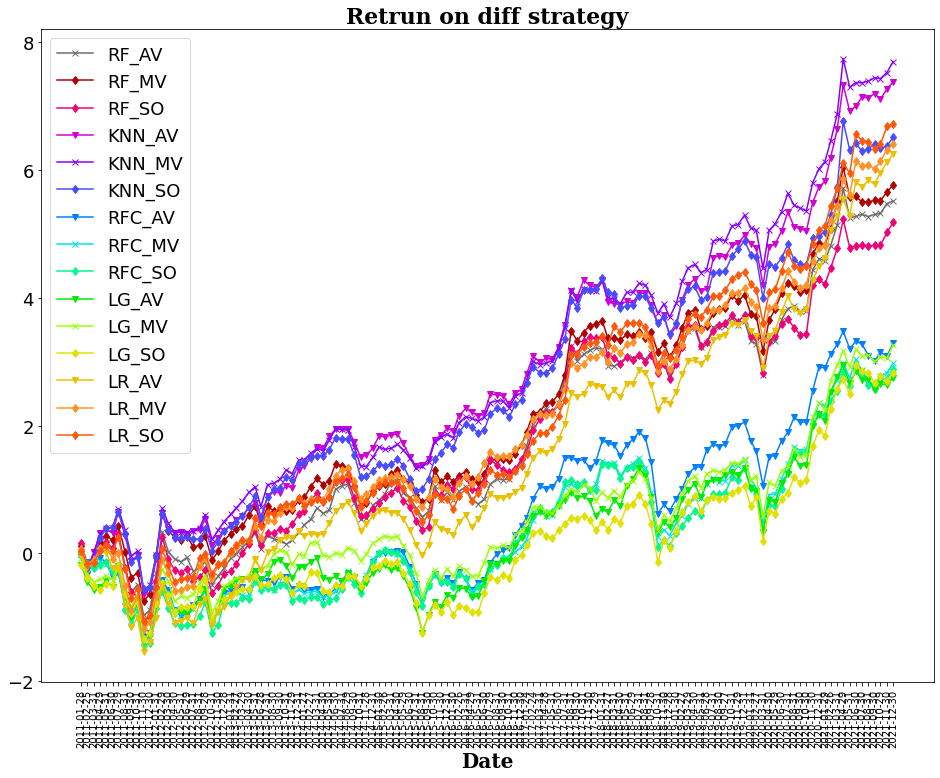

In [39]:
plt.figure(figsize=(16,12))
plt.plot(acc_df.Date, acc_df.RF_均等權重法, color='#6C6C6C', label='RF_AV', marker='x')
plt.plot(acc_df.Date, acc_df.RF_平均數變異數法, color='#AE0000', label = 'RF_MV', marker='d')
plt.plot(acc_df.Date, acc_df.RF_夏普最優, color='#F00078', label = 'RF_SO', marker='d')
plt.plot(acc_df.Date, acc_df.KNN_均等權重法, color='#D200D2', label = 'KNN_AV', marker='v')
plt.plot(acc_df.Date, acc_df.KNN_平均數變異數法, color='#8600FF', label='KNN_MV', marker='x')
plt.plot(acc_df.Date, acc_df.KNN_夏普最優, color='#4A4AFF', label = 'KNN_SO', marker='d')
plt.plot(acc_df.Date, acc_df.RFC_均等權重法, color='#0080FF', label = 'RFC_AV', marker='v')
plt.plot(acc_df.Date, acc_df.RFC_平均數變異數法, color='#00E3E3', label='RFC_MV', marker='x')
plt.plot(acc_df.Date, acc_df.RFC_夏普最優, color='#02F78E', label = 'RFC_SO', marker='d')
plt.plot(acc_df.Date, acc_df.LG_均等權重法, color='#00EC00', label = 'LG_AV', marker='v')
plt.plot(acc_df.Date, acc_df.LG_平均數變異數法, color='#9AFF02', label='LG_MV', marker='x')
plt.plot(acc_df.Date, acc_df.LG_夏普最優, color='#E1E100', label = 'LG_SO', marker='d')
plt.plot(acc_df.Date, acc_df.LR_均等權重法, color='#EAC100', label = 'LR_AV', marker='v')
plt.plot(acc_df.Date, acc_df.LR_平均數變異數法, color='#FF9224', label = 'LR_MV', marker='d')
plt.plot(acc_df.Date, acc_df.LR_夏普最優, color='#FF5809', label = 'LR_SO', marker='d')
#plt.plot(acc_df.Date, acc_df.Index, color='#AD5A5A', label='INDEX', marker='x')
#plt.plot(acc_df.Date, acc_df.etf, color='#A5A552', label='ETF0050', marker='x')

plt.legend(loc='upper left', prop={'size':18})
plt.xlabel('Date',fontdict={'family': 'serif', 'color' : 'black','weight':'bold','size': 20})
plt.ylabel('',fontdict={'family': 'serif', 'color' : 'black','weight':'bold','size': 20})
plt.xticks(acc_df.Date, rotation='vertical')
plt.yticks(fontsize=18)
plt.title('Retrun on diff strategy', x=0.5, y=1, fontdict={'family': 'serif', 
        'color' : 'black','weight': 'bold','size': 22})

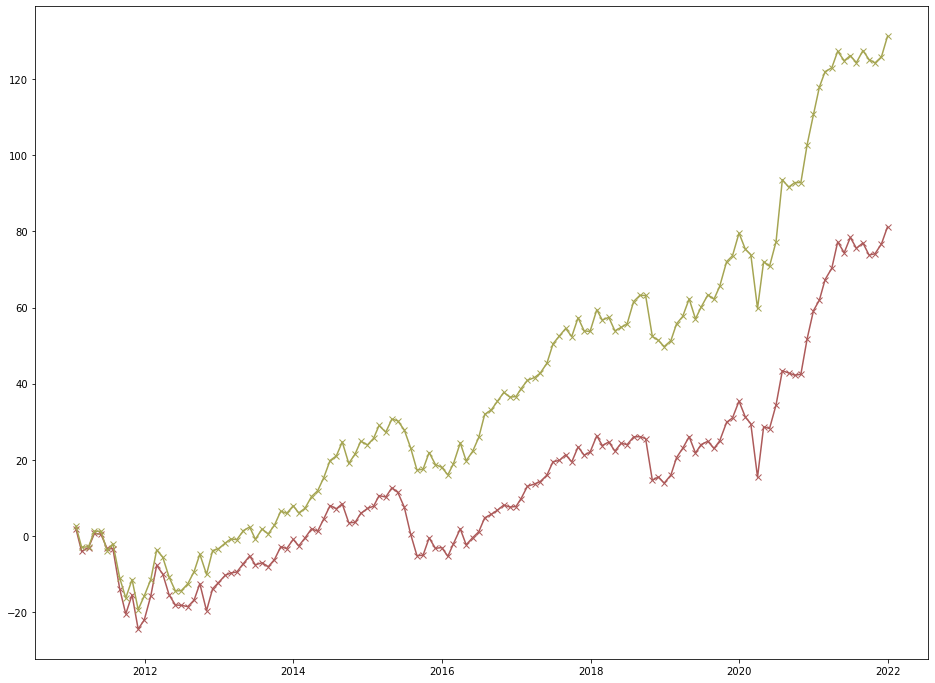

In [38]:
plt.figure(figsize=(16,12))
plt.plot(acc_df.Date, acc_df.Index, color='#AD5A5A', label='INDEX', marker='x')
plt.plot(acc_df.Date, acc_df.etf, color='#A5A552', label='ETF0050', marker='x')